In [1]:
%matplotlib inline

In [3]:
pwd

'/home/andre/Projects/stocks/prototypes'

In [4]:
cd ..

/home/andre/Projects/stocks


In [5]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
from Tools.util import progressbar
from Tools import prepareData, torchNN, torchCV
from Tools import meta5Ibov 
from Tools import backtest
import seaborn as sns
import talib as ta
import multiprocessing
from scipy import stats

### Total Random Search of parameters

- Evaluate if EMA trend can be used for prediction
- What is the best parameter configuration for profiting
- What is the needed accuracy of the NN model that will make Binary Classification (forecast-prediction)

#### Variables
1. lag (time lag shift)
2. clip (decision cut-off)
3. percent of wrong binary classifications (random)
4. minimal profit (directly related to risk-appetite)
5. expected variation (mean volatility expected)
6. reward-risk-ratio 

#### Metrics average of 10 scenarios

1. accuracy 
2. percentiles of money variation 
    1. P0
    2. P1
    3. P50
3. sortino
4. profit
5. average number of orders

In [4]:
def paramcase(params):
    prices, X, lag, clip, rand = params
    X["y"] = np.nan
    X["ema"] = ta.EMA(X.C.values, lag)
    X.loc[ X.C > X.ema, 'y'] = 1
    X.loc[ X.C < X.ema, 'y'] = 0
    X.y = X.y.shift(-lag) 
    y = X.y.dropna()    
    Yn = pd.DataFrame(index=y.index)
    Yn['dir'] = y.values
    # include the percentage of random samples
    wrongp = np.random.randint(0, len(Yn), int(len(Yn)*rand))
    wrongv = np.random.randint(0, 2, int(len(Yn)*rand))
    Yn.iloc[wrongp, 0] = wrongv
    # calculate decision cut-off 
    sumy = np.convolve(Yn.dir.values, np.ones(lag), mode='valid')
    sumy = np.concatenate((np.ones(lag)*np.nan, sumy))[:-1]
    Yn['ysum'] = sumy
    Yn['dir'] = np.nan # direction up/down based on cut-off
    Yn.loc[Yn.ysum > clip*lag, 'dir'] = 1
    Yn.loc[Yn.ysum <= (1.-clip)*lag, 'dir'] = -1
    Yn = prepareData.removedayBorders(Yn, int(lag))
    Yn.dropna(inplace=True) # in any case
    Yn.drop(columns=['ysum'], inplace=True)    
    case = [] # store simulation metrics
    expectvar = stats.uniform(0.01, 0.06) # uniform from [0.01, 0.07]
    mprofit = stats.uniform(300, 4000) # uniform from [300, 4100]
    statrwr = stats.uniform(2, 5) # uniform from [2, 7]
    if int(len(Yn)*0.03) < 25: # a litlle greater than 10 scenarios
        case.append([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                     lag, clip, rand, np.nan, np.nan, np.nan])         
        return case
    for i in range(10):
        isamples = np.random.randint(0, len(Yn), int(len(Yn)*0.03)) #3%
        Y = Yn.iloc[isamples].copy()
        Y.sort_index(inplace=True)
        strategytester = backtest.strategyTester(prices, Y)
        pft = mprofit.rvs()
        var = expectvar.rvs()
        rwr = int(statrwr.rvs())
        # 20 random cenarios 6 months no need to discount for border removal
        ssize = 6*22*7*60 # scenario size
        strategytester.setupScenarios(ssize, False) # calculate number of possible scenarios
        accuracy, perc, sortino, profit, avgorders = 0, np.zeros(3), 0., 0., 0.
        for i in np.random.randint(0, strategytester.nscenarios, 10):
            strategytester.Scenario(i, ssize, 50000, 10, 2, 60, pft, var, lag, rwr)                      
            accuracy += strategytester.avgAccuracy()      
            perc += strategytester.basePercentis() # p0, p10, p50         
            sortino += strategytester.sortina()
            profit += strategytester.profit()
            avgorders += strategytester.avgOrdersDay()
        accuracy /= 10. # average of 10 cases
        perc /= 10.
        sortino /= 10.
        profit /= 10.
        avgorders /= 10.
        case.append([accuracy, perc[0], perc[1], perc[2], profit, sortino, avgorders, 
                     lag, clip, rand, pft, var, rwr])     
    return case

In [5]:
if __name__ == '__main__':
    #datapath = r'C:\Users\alferreira\Downloads\stocks\data'
    datapath = r'/home/andre/Projects/stocks/data'
    meta5Ibov.setDataPath(datapath, datapath, verbose=False)
    meta5Ibov.loadMeta5Data()
    prices = meta5Ibov.getSymbol("PETR4")
    #lag=90
    #clip=10
    X = prices[["C"]].copy()
     # random samples
    size=200
    rand = stats.uniform(0.05, 0.35) # [0.05, 0.4]
    lag = stats.uniform(60, 180) # [60, 60+180=240]
    clip = stats.uniform(0.66, 0.30) # equivalent to [0.95, 0.65]
    pool = multiprocessing.Pool(2) #creates a pool of process, controls worksers
    metrics = pool.map(paramcase, [[prices.copy(), X.copy(), int(lag.rvs()), 
                                    clip.rvs(), rand.rvs()] for i in range(size)]) #make our results with a map call
    pool.close() #we are not adding any more processes
    pool.join() #tell it to wait until all threads are done before going on
    armetrics = np.empty((0,13))
    for lt in metrics:
        armetrics = np.append(armetrics, np.array(lt))
    armetrics = armetrics.reshape((armetrics.size//13,13))
    dfmetrics = pd.DataFrame(armetrics, columns=['acc', 'p0', 'p10', 'p50', 'profit', 'sortino', 'avgorders',
                                                 'lag', 'clip', 'rand', 'mprof', 'exvar', 'rwr'])
    dfmetrics.to_pickle('dfmetrics_rand1.pickle')

Master data loaded size (minutes):  505242
Symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']
Using previous loaded data!
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no executed orders
there are no e

### Analysing Random Search of parameters Result

In [7]:
cd prototypes/

/home/andre/Projects/stocks/prototypes


In [8]:
dfmetrics = pd.read_pickle('dfmetrics_rand1.pickle').append(pd.read_pickle('dfmetrics_rand2.pickle')).append(pd.read_pickle('dfmetrics_rand3.pickle'))

In [9]:
dfmetrics.dropna(inplace=True)

In [10]:
dfmetrics.reset_index(drop=True, inplace=True)

In [11]:
dfmetrics.drop(columns=['profit', 'p0', 'p10', 'p50', 'avgorders'], inplace=True) # unecessary columns

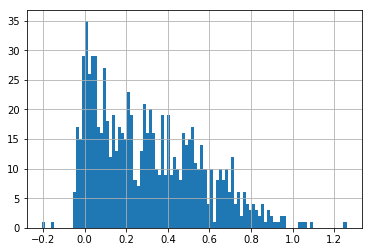

In [13]:
dfmetrics.sortino.hist(bins=100)

In [14]:
dfmetrics.sortino.describe()

count    837.000000
mean       0.301675
std        0.254324
min       -0.203764
25%        0.077414
50%        0.268218
75%        0.488068
max        1.258593
Name: sortino, dtype: float64

In [15]:
sortinos = np.linspace(-0.2, 1.26, 50, dtype=float)

In [16]:
sortinos

array([-0.2       , -0.17020408, -0.14040816, -0.11061224, -0.08081633,
       -0.05102041, -0.02122449,  0.00857143,  0.03836735,  0.06816327,
        0.09795918,  0.1277551 ,  0.15755102,  0.18734694,  0.21714286,
        0.24693878,  0.27673469,  0.30653061,  0.33632653,  0.36612245,
        0.39591837,  0.42571429,  0.4555102 ,  0.48530612,  0.51510204,
        0.54489796,  0.57469388,  0.6044898 ,  0.63428571,  0.66408163,
        0.69387755,  0.72367347,  0.75346939,  0.78326531,  0.81306122,
        0.84285714,  0.87265306,  0.90244898,  0.9322449 ,  0.96204082,
        0.99183673,  1.02163265,  1.05142857,  1.08122449,  1.11102041,
        1.14081633,  1.17061224,  1.20040816,  1.23020408,  1.26      ])

In [17]:
sortinos = sortinos+0.015
dfmetrics['sortinoc'] = pd.cut(dfmetrics['sortino'], bins=50, labels=sortinos)

In [18]:
sortinoc = dfmetrics.groupby(by='sortinoc').mean().sort_values(by='sortino', ascending=False)

In [19]:
dfmetrics.head()

,acc,sortino,lag,clip,rand,mprof,exvar,rwr,sortinoc
0,0.817879,0.039204,132.0,0.845451,0.171666,374.989540,0.046985,5.0,0.053367
1,0.859717,0.188828,132.0,0.845451,0.171666,1473.962640,0.048091,6.0,0.202347
2,0.804663,0.075717,132.0,0.845451,0.171666,381.225137,0.033814,4.0,0.083163
3,0.822116,0.245829,132.0,0.845451,0.171666,1338.383914,0.042145,5.0,0.261939
4,0.630030,0.167019,132.0,0.845451,0.171666,702.547334,0.019492,4.0,0.172551


In [22]:
dfmetrics['sortinoc'] = dfmetrics.sortinoc.round(2)

In [23]:
sns.set_style('ticks')
sns.set_context("talk", font_scale=0.8)

In [24]:
dfmetrics.head(3)

,acc,sortino,lag,clip,rand,mprof,exvar,rwr,sortinoc
0,0.817879,0.039204,132.0,0.845451,0.171666,374.989540,0.046985,5.0,0.05
1,0.859717,0.188828,132.0,0.845451,0.171666,1473.962640,0.048091,6.0,0.20
2,0.804663,0.075717,132.0,0.845451,0.171666,381.225137,0.033814,4.0,0.08


### Tunned parameters almost uncessary simulation

- clip < 0.8 
- mprof >> 
- exvar > 0.05
- lag < 90
- rand < 20% or NN acc > 80%

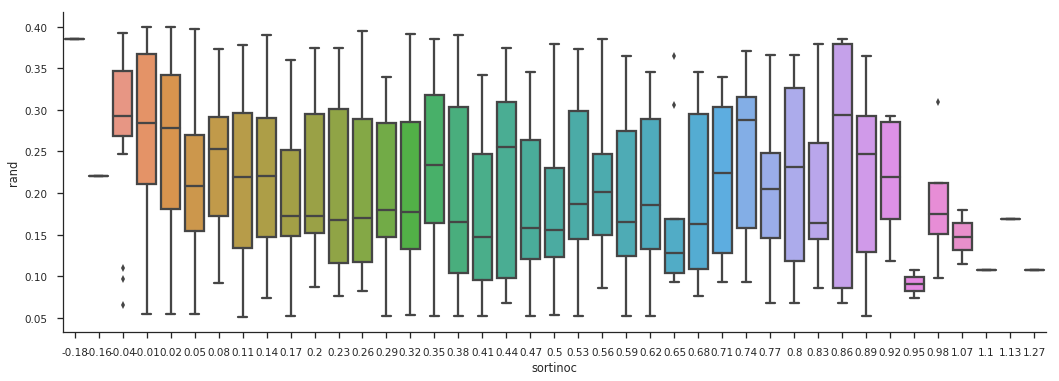

In [26]:
f = sns.factorplot('sortinoc', 'rand', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

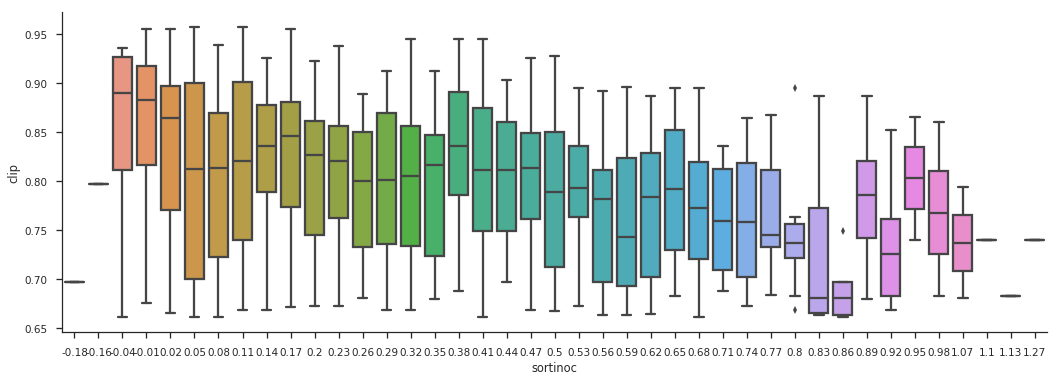

In [33]:
f = sns.factorplot('sortinoc', 'clip', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

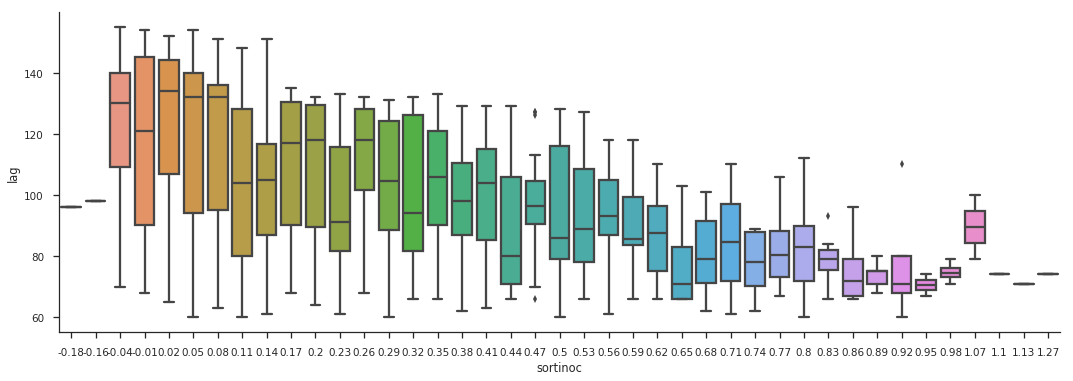

In [34]:
f = sns.factorplot('sortinoc', 'lag', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

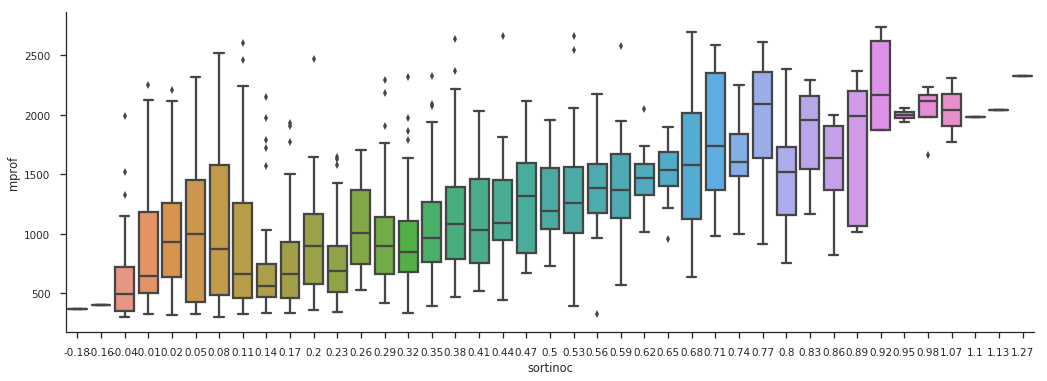

In [35]:
f = sns.factorplot('sortinoc', 'mprof', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

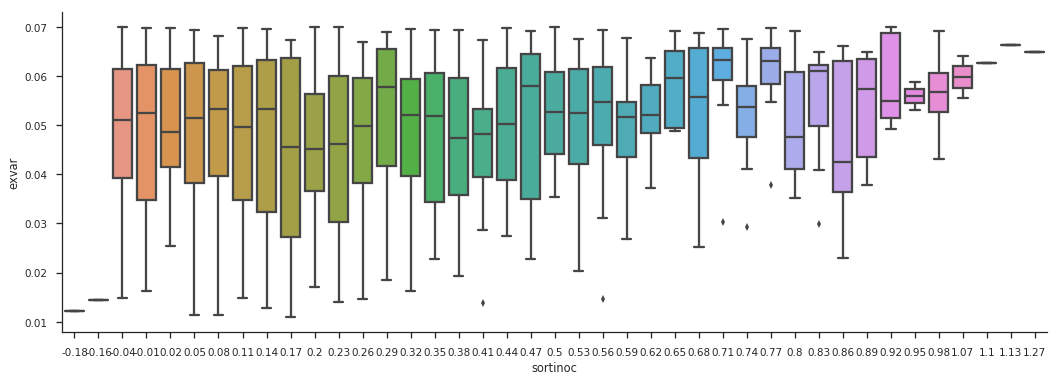

In [36]:
f = sns.factorplot('sortinoc', 'exvar', data=dfmetrics, kind='box')#, ax=ax);
f.fig.set_size_inches(20, 6)
f.despine()

## Best Lag 

Around 120 minutes there was another but due need of   
as many as possible entry points 74 is better

In [29]:
dfmetrics.sort_values(by='sortino', ascending=False).head(100)['lag'].mode()

0    71.0
dtype: float64

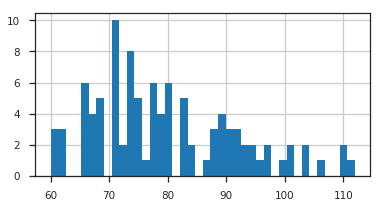

In [30]:
plt.figure(figsize=(6,3))
dfmetrics.sort_values(by='sortino', ascending=False).head(100)['lag'].hist(bins=40)

## Best clip

Too much clip make no predictions  
too few no certainty that will go up or down  


In [37]:
dfmetrics.sort_values(by='sortino', ascending=False).head(100)['clip'].mode()

0    0.682704
1    0.740422
dtype: float64

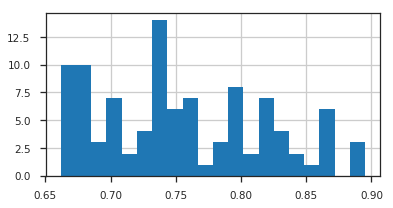

In [32]:
plt.figure(figsize=(6,3))
dfmetrics.sort_values(by='sortino', ascending=False).head(100)['clip'].hist(bins=20)

## Stop/Gain Variation

(0.008+0.01)/2.

### Biased by the fact that most predictions are correct so the higher the better .... 

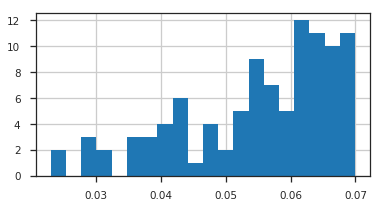

In [39]:
plt.figure(figsize=(6,3))
dfmetrics.sort_values(by='sortino', ascending=False).head(100)['exvar'].hist(bins=20)

## Acquiring more samples for the chosen parameters

2000 samples to analyse its behavior (PDF)

In [43]:
# import importlib
# importlib.reload(meta5Ibov)
# importlib.reload(backtest)
datapath = r'/home/andre/Projects/stocks/data'
meta5Ibov.setDataPath(datapath, datapath, verbose=False)
meta5Ibov.loadMeta5Data()
prices = meta5Ibov.getSymbol("PETR4")
X = prices[["C"]].copy()
#paramcase([prices.copy(), X.copy(), 160, 0.92])

Master data loaded size (minutes):  505242
Symbols loaded:
['PETR4' 'BBDC4' 'VALE3' 'DOL$' 'ITUB4' 'WIN@' 'B3SA3' 'BBAS3' 'ABEV3']
Using previous loaded data!


In [44]:
params = [prices.copy(), X.copy(), 71, 0.73] 

In [47]:
prices, X, lag, clip = params
X["y"] = np.nan
X["ema"] = ta.EMA(X.C.values, lag)
X.loc[ X.C > X.ema, 'y'] = 1
X.loc[ X.C < X.ema, 'y'] = 0
X.y = X.y.shift(-lag) 
y = X.y.dropna()    
Yn = pd.DataFrame(index=y.index)
Yn['dir'] = y.values
sumy = np.convolve(Yn.dir.values, np.ones(lag), mode='valid')
sumy = np.concatenate((np.ones(lag)*np.nan, sumy))[:-1]
Yn['ysum'] = sumy
Yn['dir'] = np.nan
Yn.loc[Yn.ysum > clip*lag, 'dir'] = 1
Yn.loc[Yn.ysum <= (1.-clip)*lag, 'dir'] = -1
Yn = prepareData.removedayBorders(Yn, int(lag))
Yn.dropna(inplace=True)
Yn.drop(columns=['ysum'], inplace=True)    
case = []
isamples = np.random.randint(0, len(Yn), int(len(Yn)*0.03)) #3% pattern will be identified (assumption)
Y = Yn.iloc[isamples].copy()
Y.sort_index(inplace=True)
strategytester = backtest.strategyTester(prices, Y)
# random cenarios 1 months discount for border removal
simsize = 22*(7*60) # scenario size
strategytester.setupScenarios(simsize) # calculate number of possible scenarios
for i in progressbar(np.random.randint(0, strategytester.nscenarios, 2000)):
    strategytester.Scenario(i, simsize, 50000, 10, 2, 60, 1800., 0.05, lag)                      
    accuracy = strategytester.avgAccuracy()      
    perc = strategytester.basePercentis() # p0, p10, p50         
    sortino = strategytester.sortina()
    profit = strategytester.profit()
    avgorders = strategytester.avgOrdersDay()
    case.append([accuracy, perc[0], perc[1], perc[2], profit, sortino, avgorders])      

number of possible scenarios 6125
[################################################################################] 2000/2000


In [54]:
(50000*0.05/3.)/50000 #appetite to risk per order

0.016666666666666666

[1.42307692 1.52       1.64       1.875      2.1205    ]
[0.01810001 0.02952375 0.05168801 0.13346923 0.25219324]
[0.026292   0.03771916 0.059828   0.141982   0.260308  ]
[0.58536585 0.63040494 0.69565217 0.76923077 0.85365854]


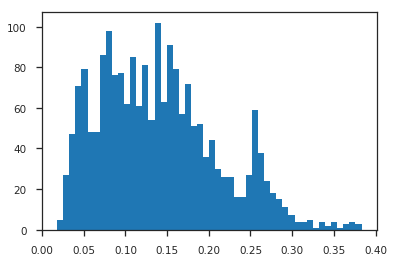

In [50]:
case = np.array(case)
plt.hist(case[:, -2], bins=50);
print(np.percentile(case[:, -1], [0, 1, 10, 50, 90]))
print(np.percentile(case[:, -2], [0, 1, 10, 50, 90]))
print(np.percentile(case[:, -3], [0, 1, 10, 50, 90]))
print(np.percentile(case[:, 0], [0, 1, 10, 50, 90]))

### What is the acceptable accuracy of NN model for profiting?

Mix correct predictions with noise in the desired proportions  

- 40% random, so 60% correct predictions  
- A pdf with p50 of 60% accuracy would give the same result?  
- I guess I dont know...


In [73]:
params = [prices.copy(), X.copy(), 71, 0.73] 

In [74]:
prices, X, lag, clip = params
X["y"] = np.nan
X["ema"] = ta.EMA(X.C.values, lag)
X.loc[ X.C > X.ema, 'y'] = 1
X.loc[ X.C < X.ema, 'y'] = 0
X.y = X.y.shift(-lag) 
y = X.y.dropna()    
Yn = pd.DataFrame(index=y.index)
Yn['dir'] = y.values

### Mix with 40% of random noise

- Assuming that is equivalent to a NN model with a pdf with P50 = 60% accuracy.


In [75]:
wrongp = np.random.randint(0, len(Yn), int(len(Yn)*0.40))
wrongv = np.random.randint(0, 2, int(len(Yn)*0.40))
Yn.iloc[wrongp, 0] = wrongv

In [76]:
sumy = np.convolve(Yn.dir.values, np.ones(lag), mode='valid')
sumy = np.concatenate((np.ones(lag)*np.nan, sumy))[:-1]
Yn['ysum'] = sumy
Yn['dir'] = np.nan
Yn.loc[Yn.ysum > clip*lag, 'dir'] = 1
Yn.loc[Yn.ysum <= (1.-clip)*lag, 'dir'] = -1
Yn = prepareData.removedayBorders(Yn, int(lag))
Yn.dropna(inplace=True)
Yn.drop(columns=['ysum'], inplace=True)    
case = []
if int(len(Yn)*0.03) < 25: # a litlle greater than 10 scenarios
    print("Uow too few!")
isamples = np.random.randint(0, len(Yn), int(len(Yn)*0.03)) #3%
Y = Yn.iloc[isamples].copy()
Y.sort_index(inplace=True)
strategytester = backtest.strategyTester(prices, Y)
# random cenarios 1 months discount for border removal
simsize = 22*7*60 # scenario size
strategytester.setupScenarios(simsize, False) # calculate number of possible scenarios
for i in progressbar(np.random.randint(0, strategytester.nscenarios, 2000)):
    strategytester.Scenario(i, simsize, 50000, 10, 2, 60, 1800., 0.05, lag)                      
    accuracy = strategytester.avgAccuracy()      
    perc = strategytester.basePercentis() # p0, p10, p50         
    sortino = strategytester.sortina()
    profit = strategytester.profit()
    avgorders = strategytester.avgOrdersDay()
    case.append([accuracy, perc[0], perc[1], perc[2], profit, sortino, avgorders])   

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


[################################################################################] 2000/2000


[1.         1.07692308 1.2        1.4        1.6       ]
[0.02581967 0.03454779 0.05935991 0.12564123 0.21473323]
[0.032984   0.04253572 0.0676048  0.134118   0.2227588 ]
[0.62857143 0.67857143 0.74285714 0.82891986 0.91428571]
[-0.045892  -0.0179302 -0.008002  -0.00328   -0.00156  ]


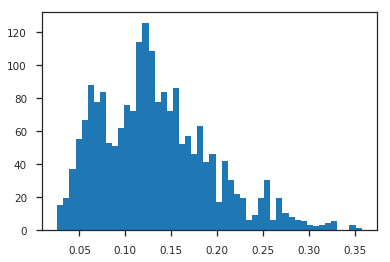

In [77]:
case = np.array(case)
plt.hist(case[:, -2], bins=50);
print(np.percentile(case[:, -1], [0, 1, 10, 50, 90]))
print(np.percentile(case[:, -2], [0, 1, 10, 50, 90]))
print(np.percentile(case[:, -3], [0, 1, 10, 50, 90]))
print(np.percentile(case[:, 0], [0, 1, 10, 50, 90]))
print(np.percentile(case[:, 1], [0, 1, 10, 50, 90]))

Conclusions one month scenario:

- The NN models need P50 accuracy of 60% to make profit or less.     
    - P90 for profit is 6% and P50 is 13% 
    - Even  P90 is low 0.9% per month.
    
- Maybe changing how orders are placed, stop/loss, including reduction, move stop/loss up, could also improve accuracy. 